### Прогнозування часу за допомогою методу групового урахування аргументів (МГУА)

In [30]:
# Imports
import os
import random
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)
os.environ['PYTHONHASHSEED'] = '42'
os.environ['TF_DETERMINISTIC_OPS'] = '1'

In [31]:
# %% [2] Load and preprocess data
def load_data(filepath, train_ratio=0.6, selection_ratio=0.2):
    """
    Load and preprocess data for GMDH algorithm with three-way split.
    
    Args:
        filepath: Path to the data file
        train_ratio: Ratio for training set (default 0.6)
        selection_ratio: Ratio for selection set (default 0.2)
        (remaining ratio will be used for validation)
    """
    # Load the data
    df = pd.read_csv(filepath)
    
    # Convert Time to datetime with explicit format (day first)
    df['Time'] = pd.to_datetime(df['Time'], format='%d-%m-%Y %H:%M')
    
    # Select features (excluding Location)
    feature_columns = ['Temp_2m', 'RelHum_2m', 'DP_2m', 'WS_10m', 'WS_100m', 
                      'WD_10m', 'WD_100m', 'WG_10m', 'Power']
    
    # Create feature matrix
    data = df[feature_columns].values
    
    # Determine split indices
    total_samples = data.shape[0]
    train_end = int(train_ratio * total_samples)
    selection_end = int((train_ratio + selection_ratio) * total_samples)
    
    # Split the data
    train_data = data[:train_end]
    selection_data = data[train_end:selection_end]
    val_data = data[selection_end:]
    
    # Initialize scalers
    feature_scaler = StandardScaler()
    target_scaler = StandardScaler()
    
    # Fit the feature scaler on training features only
    scaled_train_features = feature_scaler.fit_transform(train_data[:, :-1])
    scaled_selection_features = feature_scaler.transform(selection_data[:, :-1])
    scaled_val_features = feature_scaler.transform(val_data[:, :-1])
    
    # Fit the target scaler on training target
    scaled_train_target = target_scaler.fit_transform(train_data[:, -1].reshape(-1,1)).flatten()
    scaled_selection_target = target_scaler.transform(selection_data[:, -1].reshape(-1,1)).flatten()
    scaled_val_target = target_scaler.transform(val_data[:, -1].reshape(-1,1)).flatten()
    
    # Combine scaled features with scaled target
    scaled_train_data = np.column_stack((scaled_train_features, scaled_train_target))
    scaled_selection_data = np.column_stack((scaled_selection_features, scaled_selection_target))
    scaled_val_data = np.column_stack((scaled_val_features, scaled_val_target))
    
    print("Data shapes after scaling and splitting:")
    print(f"Training data shape: {scaled_train_data.shape}")
    print(f"Selection data shape: {scaled_selection_data.shape}")
    print(f"Validation data shape: {scaled_val_data.shape}")
    
    return scaled_train_data, scaled_selection_data, scaled_val_data, feature_scaler, target_scaler

In [32]:
# [3] Create sliding windows for GMDH
def create_windows(data, window_size=12, target_col=-1):
    """
    Create sliding windows from time series data for GMDH.
    
    Args:
        data: numpy array of shape (n_samples, n_features)
        window_size: number of time steps to use for input
        target_col: index of target column (default: -1 for Power)
    
    Returns:
        X: numpy array of shape (n_samples - window_size, window_size, n_features)
        y: numpy array of shape (n_samples - window_size,)
    """
    X, y = [], []
    
    for i in range(len(data) - window_size):
        window = data[i:(i + window_size)]
        target = data[i + window_size, target_col]
        
        X.append(window)
        y.append(target)
    
    return np.array(X), np.array(y)

In [33]:
# [4] Loading and processing
if __name__ == "__main__":
    # Load and preprocess data
    train_data, selection_data, val_data, feature_scaler, target_scaler = load_data('../data/raw/Train.csv')
    
    # Create windows
    X_train, y_train = create_windows(train_data)
    X_selection, y_selection = create_windows(selection_data)
    X_val, y_val = create_windows(val_data)
    
    print("\nWindowed dataset shapes:")
    print(f"X_train: {X_train.shape}")
    print(f"y_train: {y_train.shape}")
    print(f"X_selection: {X_selection.shape}")
    print(f"y_selection: {y_selection.shape}")
    print(f"X_val: {X_val.shape}")
    print(f"y_val: {y_val.shape}")

Data shapes after scaling and splitting:
Training data shape: (84096, 9)
Selection data shape: (28032, 9)
Validation data shape: (28032, 9)

Windowed dataset shapes:
X_train: (84084, 12, 9)
y_train: (84084,)
X_selection: (28020, 12, 9)
y_selection: (28020,)
X_val: (28020, 12, 9)
y_val: (28020,)


In [34]:
# [5] PolynomialNeuron and fitting function with flattened inputs

import tensorflow as tf
import numpy as np

def fit_polynomial_neuron(X_train_in, y_train, feature_pair, polynomial_type):
    """
    Fit a polynomial neuron given two input variables (from flattened windowed input).
    X_train_in: shape (n_samples, W*F) where W is window_size and F is n_features.
    """
    i, j = feature_pair
    xi = X_train_in[:, i]
    xj = X_train_in[:, j]

    if polynomial_type == 'linear':
        # f(x_i, x_j) = A0 + A1*x_i + A2*x_j
        X_mat = np.column_stack([
            np.ones_like(xi),
            xi,
            xj
        ])
    elif polynomial_type == 'incomplete_quadratic':
        # f(x_i, x_j) = A0 + A1*x_i + A2*x_j + A3*(x_i*x_j)
        X_mat = np.column_stack([
            np.ones_like(xi),
            xi,
            xj,
            xi * xj
        ])
    elif polynomial_type == 'full_quadratic':
        # f(x_i, x_j) = A0 + A1*x_i + A2*x_j + A3*x_i*x_j + A4*x_i^2 + A5*x_j^2
        X_mat = np.column_stack([
            np.ones_like(xi),
            xi,
            xj,
            xi * xj,
            xi**2,
            xj**2
        ])
    else:
        raise ValueError("Unknown polynomial_type")

    coeffs, _, _, _ = np.linalg.lstsq(X_mat, y_train, rcond=None)
    return coeffs

class PolynomialNeuron:
    def __init__(self, feature_pair, coeffs, polynomial_type):
        self.feature_pair = feature_pair
        self.coeffs = coeffs
        self.polynomial_type = polynomial_type

    def predict(self, X):
        # X is (n_samples, W*F)
        i, j = self.feature_pair
        xi = X[:, i]
        xj = X[:, j]

        if self.polynomial_type == 'linear':
            A0, A1, A2 = self.coeffs
            return A0 + A1*xi + A2*xj
        elif self.polynomial_type == 'incomplete_quadratic':
            A0, A1, A2, A3 = self.coeffs
            return A0 + A1*xi + A2*xj + A3*(xi*xj)
        elif self.polynomial_type == 'full_quadratic':
            A0, A1, A2, A3, A4, A5 = self.coeffs
            return A0 + A1*xi + A2*xj + A3*(xi*xj) + A4*(xi**2) + A5*(xj**2)
        else:
            raise ValueError("Unknown polynomial_type")

In [35]:
# [6] Updated GMDHLayer 
class GMDHLayer:
    def __init__(self, num_features, F=5, epsilon=1e-6, polynomial_type='full_quadratic'):
        self.num_features = num_features
        self.F = F 
        self.epsilon = epsilon
        self.previous_mse = None
        self.neurons = []
        self.feature_pairs = [(i, j) for i in range(num_features) for j in range(i+1, num_features)]
        self.polynomial_type = polynomial_type

    def fit_layer(self, X_train, y_train):
        # X_train is already flattened: (n_samples, W*F)
        self.neurons = []
        for pair in self.feature_pairs:
            coeffs = fit_polynomial_neuron(X_train, y_train, pair, self.polynomial_type)
            neuron = PolynomialNeuron(feature_pair=pair, coeffs=coeffs, polynomial_type=self.polynomial_type)
            self.neurons.append(neuron)

    def predict_all(self, X):
        # X is flattened
        preds = [neuron.predict(X) for neuron in self.neurons]
        return np.column_stack(preds)

    def check_stopping_criterion(self, current_mse):
        if self.previous_mse is None:
            self.previous_mse = current_mse
            return False
        diff = abs(current_mse - self.previous_mse)
        self.previous_mse = current_mse
        return diff < self.epsilon

    def select_best_neurons(self, outputs_val, y_val):
        # Simply compute MSE for each neuron's predictions
        mse_scores = []
        for i in range(outputs_val.shape[1]):
            mse = np.mean((y_val - outputs_val[:, i]) ** 2)
            mse_scores.append(mse)
        
        # Return indices of F neurons with lowest MSE
        return np.argsort(mse_scores)[:self.F]

In [36]:
# [7] Updated GMDHModel
class GMDHModel:
    def __init__(self, input_dim, max_layers=5, F=5, epsilon=1e-6, polynomial_type='full_quadratic'):
        self.max_layers = max_layers
        self.F = F
        self.epsilon = epsilon
        self.input_dim = input_dim
        self.polynomial_type = polynomial_type
        self.gmdh_layers = []
        self.best_neurons_per_layer = []
        self.feature_expressions = {i: f"X_{i}" for i in range(input_dim)}

        self.history = {
            'layer_mse': [],
            'layer_outputs_selection': [],
            'layer_outputs_val': [],
            'selected_neurons': [],
            'layer_losses_train': [],
            'layer_losses_selection': [],
            'layer_losses_val': []
        }

    def train_layer(self, X_train, y_train, X_selection, y_selection, X_val, y_val, layer_idx):
        layer = GMDHLayer(num_features=X_train.shape[-1], F=self.F, epsilon=self.epsilon, 
                         polynomial_type=self.polynomial_type)
        self.gmdh_layers.append(layer)

        # Fit neurons using training data
        layer.fit_layer(X_train, y_train)

        # Compute outputs for all sets
        outputs_train = layer.predict_all(X_train)
        outputs_selection = layer.predict_all(X_selection)
        outputs_val = layer.predict_all(X_val)

        # Select best neurons based on selection set MSE
        best_indices = layer.select_best_neurons(outputs_selection, y_selection)
        self.best_neurons_per_layer.append(best_indices)

        # Calculate losses
        train_loss = np.mean((y_train[:, np.newaxis] - outputs_train) ** 2)
        selection_loss = np.mean((y_selection[:, np.newaxis] - outputs_selection) ** 2)
        val_loss = np.mean((y_val[:, np.newaxis] - outputs_val) ** 2)
        
        # Update history
        self.history['layer_mse'].append(selection_loss)  # Using selection loss for stopping criterion
        self.history['layer_outputs_selection'].append(outputs_selection)
        self.history['layer_outputs_val'].append(outputs_val)
        self.history['selected_neurons'].append(best_indices)
        self.history['layer_losses_train'].append(train_loss)
        self.history['layer_losses_selection'].append(selection_loss)
        self.history['layer_losses_val'].append(val_loss)

        # Update expressions (same as before)
        new_feature_expressions = {}
        for i, neuron_idx in enumerate(best_indices):
            neuron = layer.neurons[neuron_idx]
            fp = neuron.feature_pair
            f1_expr = self.feature_expressions[fp[0]]
            f2_expr = self.feature_expressions[fp[1]]

            if self.polynomial_type == 'linear':
                A0, A1, A2 = neuron.coeffs
                expr = f"({A0:.4f} + {A1:.4f}*{f1_expr} + {A2:.4f}*{f2_expr})"
            elif self.polynomial_type == 'incomplete_quadratic':
                A0, A1, A2, A3 = neuron.coeffs
                expr = f"({A0:.4f} + {A1:.4f}*{f1_expr} + {A2:.4f}*{f2_expr} + {A3:.4f}*({f1_expr}*{f2_expr}))"
            elif self.polynomial_type == 'full_quadratic':
                A0, A1, A2, A3, A4, A5 = neuron.coeffs
                expr = f"({A0:.4f} + {A1:.4f}*{f1_expr} + {A2:.4f}*{f2_expr} + {A3:.4f}*({f1_expr}*{f2_expr}) + {A4:.4f}*({f1_expr}^2) + {A5:.4f}*({f2_expr}^2))"

            new_feature_expressions[i] = expr

        self.feature_expressions = new_feature_expressions
        return layer.check_stopping_criterion(selection_loss)  # Using selection loss for stopping criterion

    def synthesize(self, X_train, y_train, X_selection, y_selection, X_val, y_val):
        current_X_train = X_train
        current_X_selection = X_selection
        current_X_val = X_val

        for layer_idx in range(self.max_layers):
            print(f"Synthesizing layer {layer_idx + 1}")
            should_stop = self.train_layer(current_X_train, y_train, 
                                         current_X_selection, y_selection,
                                         current_X_val, y_val, layer_idx)
            
            if should_stop:
                print(f"Stopping criterion met at layer {layer_idx + 1}")
                break

            last_layer = self.gmdh_layers[-1]
            outputs_train = last_layer.predict_all(current_X_train)
            outputs_selection = last_layer.predict_all(current_X_selection)
            outputs_val = last_layer.predict_all(current_X_val)
            best_indices = self.best_neurons_per_layer[-1]

            current_X_train = outputs_train[:, best_indices]
            current_X_selection = outputs_selection[:, best_indices]
            current_X_val = outputs_val[:, best_indices]

    def predict(self, X):
        """
        Make predictions using the trained GMDH model.
        Args:
            X: Input data of shape (n_samples, input_dim)
        Returns:
            predictions: A numpy array of shape (n_samples, F), where F is the number of selected neurons
                        from the last layer.
        """
        if not self.gmdh_layers:
            raise ValueError("The model has no trained layers. Train the model before making predictions.")

        # Start with the input features
        layer_outputs = X

        # Pass through each trained layer
        for layer in self.gmdh_layers:
            layer_outputs = layer.predict_all(layer_outputs)

        # Only return predictions from the final layer
        return layer_outputs

In [37]:
# [8] Main execution
if __name__ == "__main__":
    # Load and preprocess data with three-way split
    train_data, selection_data, val_data, feature_scaler, target_scaler = load_data('../data/raw/Train.csv')
    
    # Create windows for all sets
    X_train, y_train = create_windows(train_data)
    X_selection, y_selection = create_windows(selection_data)
    X_val, y_val = create_windows(val_data)
    
    # Flatten the windowed data
    N_train, W, F = X_train.shape
    X_train_flat = X_train.reshape(N_train, W*F)
    
    N_selection = X_selection.shape[0]
    X_selection_flat = X_selection.reshape(N_selection, W*F)
    
    N_val = X_val.shape[0]
    X_val_flat = X_val.reshape(N_val, W*F)

    # Initialize the model
    model = GMDHModel(
        input_dim=X_train_flat.shape[-1], 
        max_layers=5, 
        F=5, 
        epsilon=1e-6, 
        polynomial_type='incomplete_quadratic'
    )
    
    # Train the model layer by layer
    for layer_idx in range(model.max_layers):
        model.train_layer(X_train_flat, y_train, X_selection_flat, y_selection, X_val_flat, y_val, layer_idx)
        
        # Check the stopping criterion
        if model.gmdh_layers[-1].check_stopping_criterion(model.history['layer_mse'][-1]):
            print(f"Stopping training at layer {layer_idx + 1} due to convergence.")
            break

    # Print final layer performance
    print("\nFinal Layer Performance:")
    print("Training Loss:", model.history['layer_losses_train'][-1])
    print("Selection Loss:", model.history['layer_losses_selection'][-1])
    print("Validation Loss:", model.history['layer_losses_val'][-1])
    
    # Example predictions
    predictions = model.gmdh_layers[-1].predict_all(X_val_flat)
    predictions_mean = predictions.mean(axis=1)
    
    # Inverse transform predictions and actual values
    predictions_mean_original = target_scaler.inverse_transform(predictions_mean.reshape(-1, 1)).flatten()
    y_val_original = target_scaler.inverse_transform(y_val.reshape(-1, 1)).flatten()

    print("\nSample Predictions (in scaled form):", predictions_mean[:5])
    print("\nSample Predictions (in original scale):", predictions_mean_original[:5])
    print("Sample Actual (original scale):", y_val_original[:5])

    # Print final model expression
    print("\nFinal Model Expression(s):")
    for expr in model.feature_expressions.values():
        print(expr)

Data shapes after scaling and splitting:
Training data shape: (84096, 9)
Selection data shape: (28032, 9)
Validation data shape: (28032, 9)
Stopping training at layer 1 due to convergence.

Final Layer Performance:
Training Loss: 0.7431068774098339
Selection Loss: 0.698159209434411
Validation Loss: 0.5961390622766144

Sample Predictions (in scaled form): [0.30908589 0.3374058  0.37061373 0.39836081 0.407016  ]

Sample Predictions (in original scale): [0.42018811 0.42755196 0.43618681 0.44340171 0.44565227]
Sample Actual (original scale): [0.63249589 0.61169589 0.59089589 0.57009589 0.54929589]

Final Model Expression(s):
(0.0001 + -0.9166*X_98 + 1.9025*X_107 + -0.0001*(X_98*X_107))
(0.0004 + -0.4388*X_89 + 1.4192*X_107 + -0.0004*(X_89*X_107))
(0.0007 + -0.2820*X_80 + 1.2581*X_107 + -0.0007*(X_80*X_107))
(0.0011 + -0.2031*X_71 + 1.1761*X_107 + -0.0013*(X_71*X_107))
(0.0016 + -0.1544*X_62 + 1.1256*X_107 + -0.0018*(X_62*X_107))


Validation R²: 0.3980227202799612
Validation MSE: 0.4766248111155484
Validation MAE: 0.5967804442584032


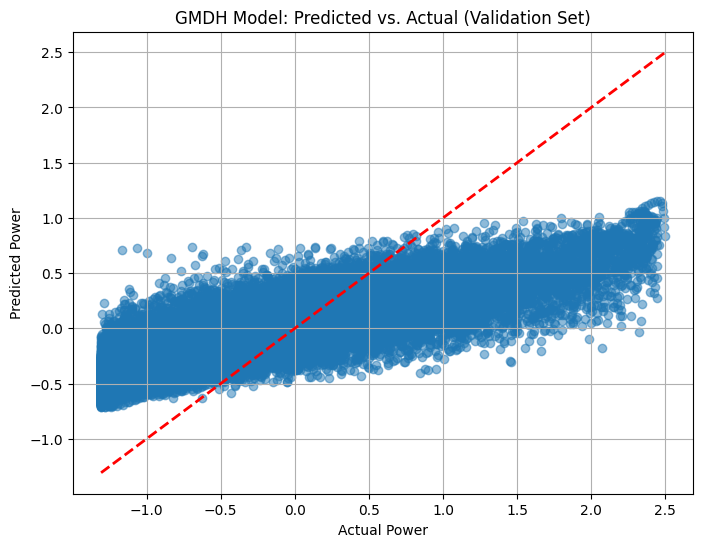

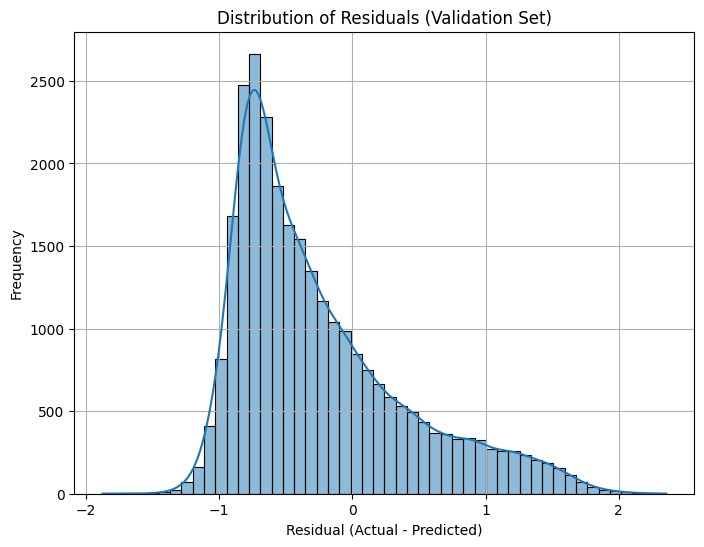

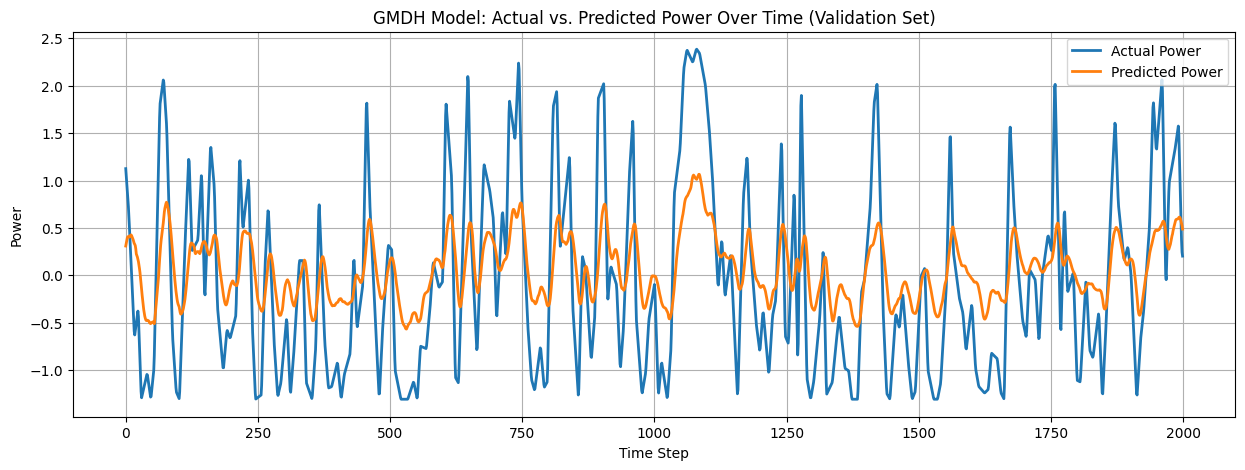

In [38]:
# [9] Evaluation and Visualization for GMDH Model

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

# Since the model expects flattened inputs, ensure we use X_val_flat:
# If X_val_flat is not defined here, we can flatten X_val:
# X_val_flat = X_val.reshape(X_val.shape[0], -1)

# Get predictions from the model
predictions_val = model.predict(X_val_flat)  # shape: (n_samples, F)
predictions_val_mean = predictions_val.mean(axis=1)  # Average across neurons

# Compute validation metrics
r2_val = r2_score(y_val, predictions_val_mean)
mse_val = mean_squared_error(y_val, predictions_val_mean)
mae_val = mean_absolute_error(y_val, predictions_val_mean)

print("Validation R²:", r2_val)
print("Validation MSE:", mse_val)
print("Validation MAE:", mae_val)

# Scatter Plot: Predicted vs Actual (Validation Set)
plt.figure(figsize=(8,6))
plt.scatter(y_val, predictions_val_mean, alpha=0.5)
plt.plot([y_val.min(), y_val.max()], [y_val.min(), y_val.max()], 'r--', linewidth=2)
plt.xlabel('Actual Power')
plt.ylabel('Predicted Power')
plt.title('GMDH Model: Predicted vs. Actual (Validation Set)')
plt.grid(True)
plt.show()

# Residual Distribution
residuals_val = y_val - predictions_val_mean
plt.figure(figsize=(8,6))
sns.histplot(residuals_val, kde=True, bins=50)
plt.xlabel('Residual (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (Validation Set)')
plt.grid(True)
plt.show()

# Line Plot: Actual vs Predicted Over Time (Validation Set)
start_idx = 0
end_idx = min(2000, len(y_val))  # adjust as needed
plt.figure(figsize=(15,5))
plt.plot(range(start_idx, end_idx), y_val[start_idx:end_idx], label='Actual Power', linewidth=2)
plt.plot(range(start_idx, end_idx), predictions_val_mean[start_idx:end_idx], label='Predicted Power', linewidth=2)
plt.xlabel('Time Step')
plt.ylabel('Power')
plt.title('GMDH Model: Actual vs. Predicted Power Over Time (Validation Set)')
plt.legend()
plt.grid(True)
plt.show()